In [26]:
import warnings
from sklearn import set_config 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, \
                    accuracy_score, f1_score, precision_score, recall_score
                    
import matplotlib.pyplot as plt
                    
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc
from pandas.plotting import scatter_matrix


from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

# **Modelos de aprendizaje automático para estimar el uso de Bicing en una estación**

Este notebook contiene el código utilizado para el proyecto de APA ***Modelos de aprendizaje automático para estimar el uso
de Bicing en una estación*** realizado por **Nicolas Llorens** y **Fernando Guirao**.

## **Estudio preliminar del dataset**

In [15]:
data = pd.read_csv('dataset_generation/dataset.csv')

data.sample(5)

,hour,day,month,year,week_day,working_day,class_day,exits,temperature,a_temperature,humidity,precipitation,rain,wind_speed,demand_satisfied
17960,8,19,1,2023,Thursday,1,2,0,4.8,-1.1,64.9,0.0,0.0,24.6,True
7694,14,17,11,2021,Wednesday,1,1,6,15.3,13.7,65.0,0.0,0.0,8.9,False
24444,12,16,10,2023,Monday,1,1,7,19.3,18.9,86.0,0.9,0.9,19.9,False
1375,7,27,2,2021,Saturday,0,3,0,6.9,4.2,89.9,0.0,0.0,11.2,True
18126,6,26,1,2023,Thursday,1,3,0,0.3,-3.8,82.7,0.0,0.0,11.5,True


### **Estadísticas descriptivas**

In [39]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hour,25536.0,NaN,NaN,NaN,11.5,6.922322,0.0,5.75,11.5,17.25,23.0
day,25536.0,NaN,NaN,NaN,15.712406,8.791936,1.0,8.0,16.0,23.0,31.0
month,25536.0,NaN,NaN,NaN,6.366541,3.3669,1.0,3.0,6.0,9.0,12.0
year,25536.0,NaN,NaN,NaN,2021.970865,0.81002,2021.0,2021.0,2022.0,2023.0,2023.0
week_day,25536,7,Friday,3648,NaN,NaN,NaN,NaN,NaN,NaN,NaN
working_day,25536.0,NaN,NaN,NaN,0.683271,0.46521,0.0,0.0,1.0,1.0,1.0
class_day,25536.0,NaN,NaN,NaN,2.18891,0.93142,1.0,1.0,3.0,3.0,3.0
exits,25536.0,NaN,NaN,NaN,2.257206,3.67823,0.0,0.0,1.0,3.0,42.0
temperature,25536.0,NaN,NaN,NaN,16.985589,7.0739,-1.6,11.6,17.0,22.5,36.8
a_temperature,25536.0,NaN,NaN,NaN,16.598367,8.969706,-6.1,9.5,16.3,24.1,40.3


### **Distribución de las variables**

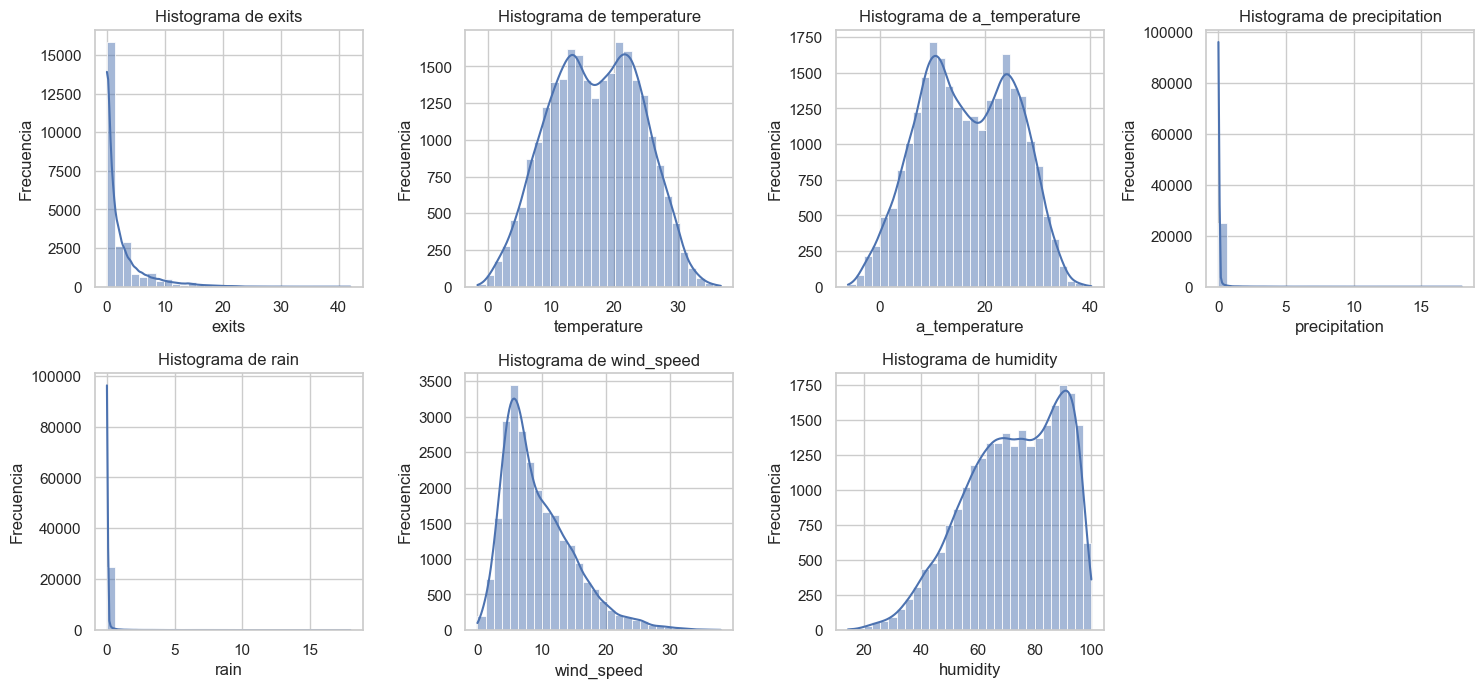

In [40]:
# Lista de variables numéricas
numeric_vars = ["exits", "temperature", "a_temperature", "precipitation", "rain", "wind_speed", "humidity"]

# Visualización de histogramas para las variables numéricas
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show();

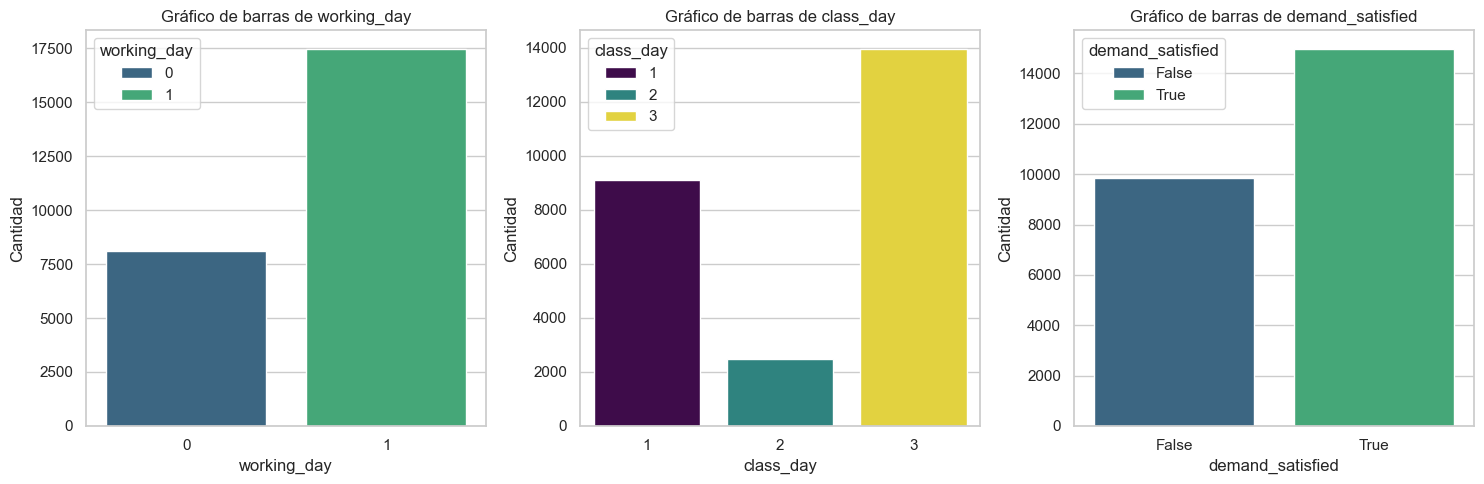

In [66]:
# Defining the list of categorical variables
categorical_vars = ['working_day', 'class_day', 'demand_satisfied']

# Plotting bar charts for categorical variables
plt.figure(figsize=(15, 5))

for i, var in enumerate(categorical_vars):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=var, data=data, hue=var, palette='viridis')
    plt.title(f'Gráfico de barras de {var}')
    plt.xlabel(var)
    plt.ylabel('Cantidad')

plt.tight_layout()
plt.show();

### **Realción de la variable objetivo con el resto de variables**

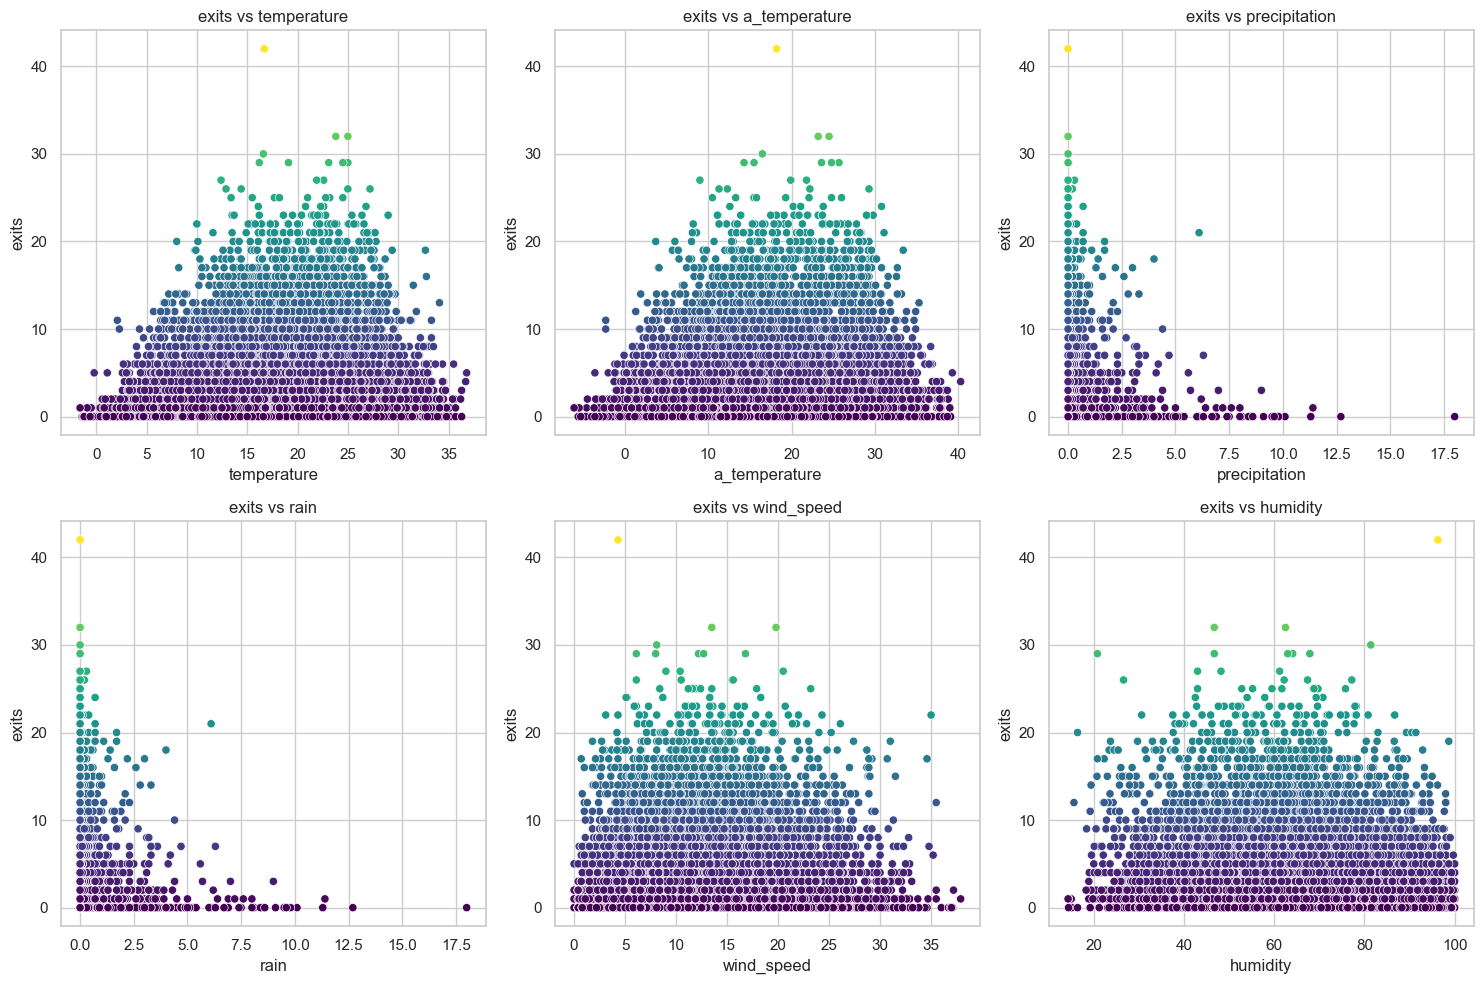

In [85]:
numeric_vars_without_exits = ["temperature", "a_temperature", "precipitation", "rain", "wind_speed", "humidity"]

# Gráficos de dispersión para variables numéricas
plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_vars_without_exits, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=data, x=var, y="exits", hue='exits', legend=False, palette="viridis")
    plt.title(f'exits vs {var}')

plt.tight_layout()
plt.show();

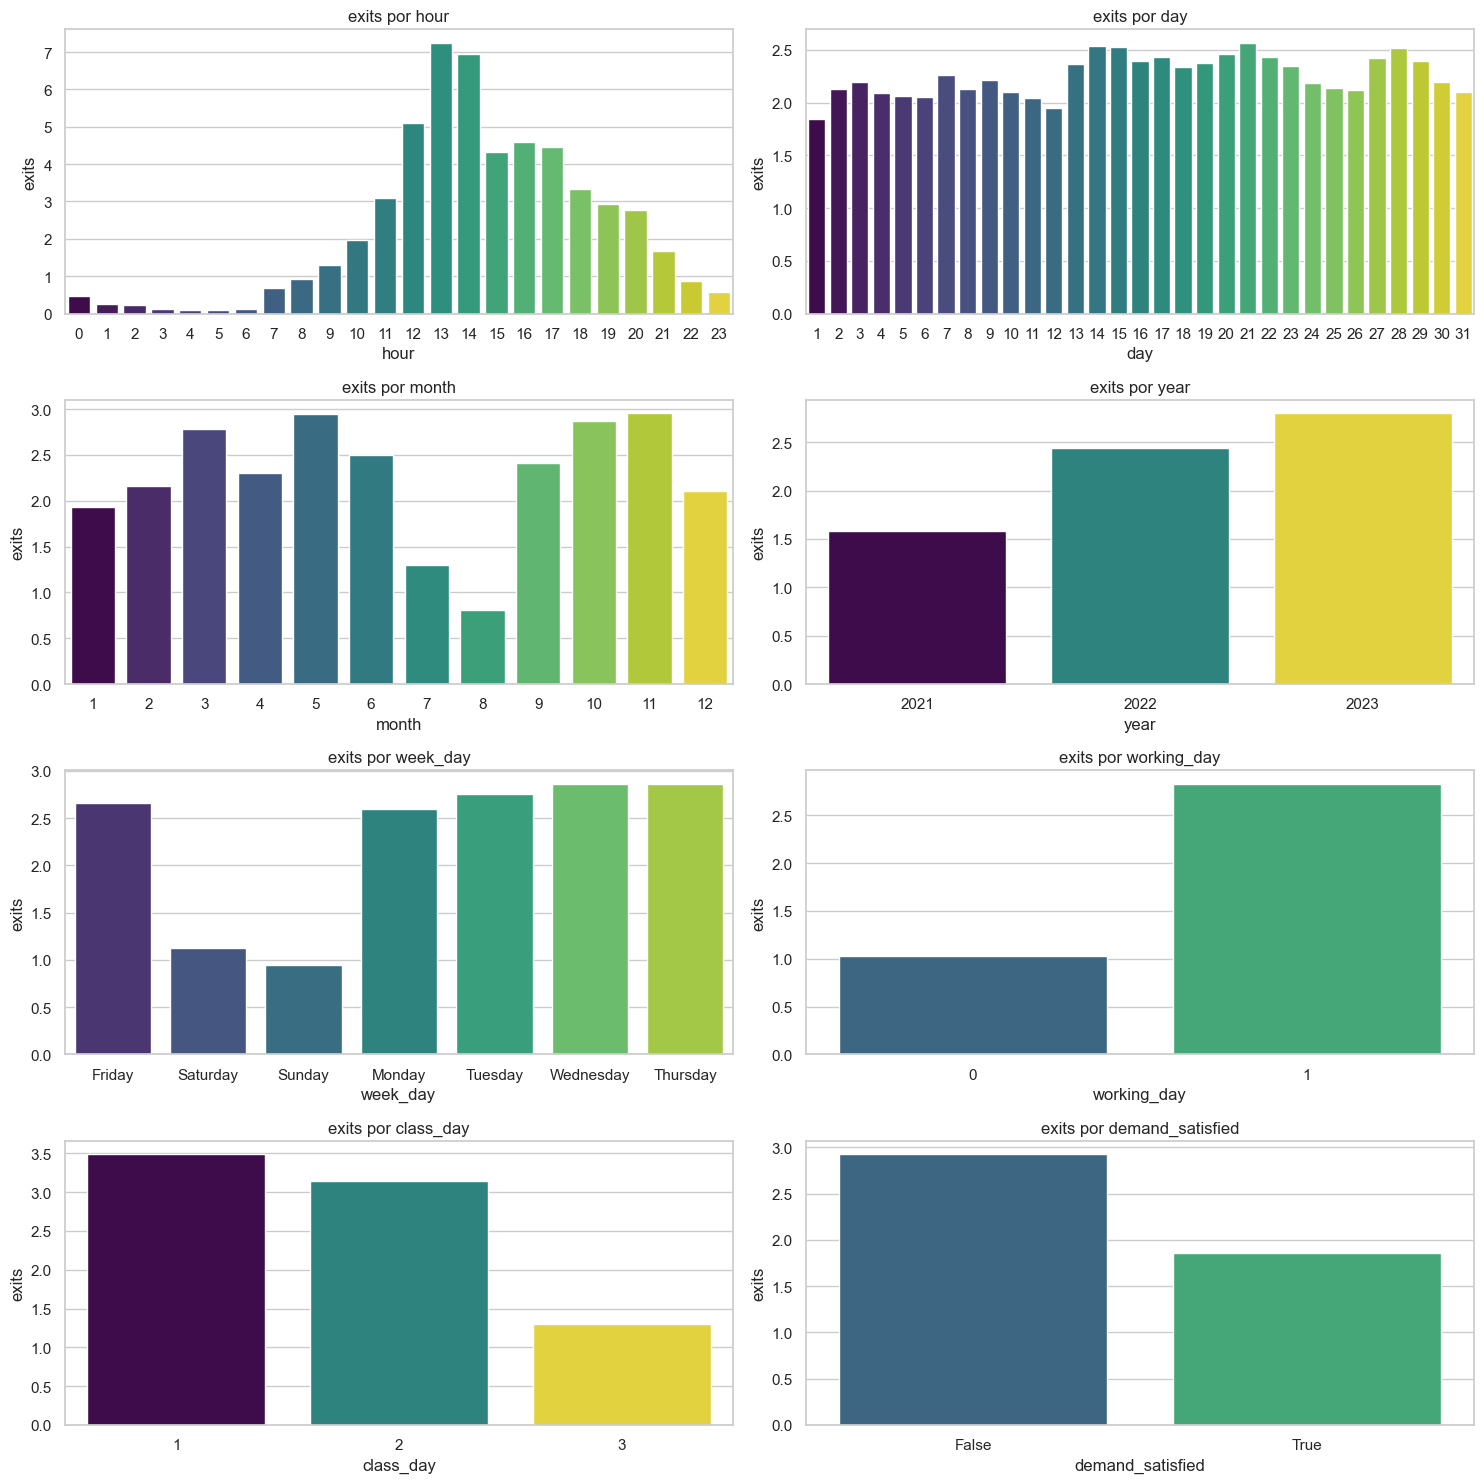

In [94]:
categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day", "demand_satisfied"]

plt.figure(figsize=(15, 15))
for i, var in enumerate(categorical_vars_selected, 1):
    plt.subplot(4, 2, i)
    sns.barplot(data=data, x=var, y="exits", errorbar=None,  hue=var, legend=False, palette="viridis") 
    plt.title(f'exits por {var}')

plt.tight_layout()
plt.show();

In [92]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

ValueError: could not convert string to float: 'Friday'